# AI Predictions (Additional Features & XAI)

The dataset used within this notebook utilises features that where used for Poisson distribution predictions and more. This means that any metrics related to the teams' performance in a particular set of matches, were data mined and served accordingly.

## Prerequisites

This section consists of necessary imports and seed setting. Seeds are set to ensure having the same dataset splits whenever the script is executed.

In [1]:
# Pandas and NumPy
import pandas as pd
import numpy as np

# Other
import random
from matplotlib import pyplot

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# TensorFlow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting a random seed to both TensorFlow (Keras) and NumPy
# This will ensure the same predictions are conducted over the same set (only changes if model paramaters change)

# https://stackoverflow.com/a/46119607/6361493
np.random.seed(42)
tf.random.set_seed(42)

## Retrieving & Cleaning The Data

This section retrieves the developed dataset (can be either queried directly from the database or by using the provided CSV).

In the `full_time_result` field:
<ul>
    <li>1 = Home Win</li>
    <li>0 = Draw</li>
    <li>2 = Away Win</li>
</ul>

In [3]:
betstats_data = pd.read_csv('football_dataset_additional_features.csv')

display(betstats_data)

fixture_id  league_season  league_id  teams_home_id  teams_away_id  \
0             115           2018         39             36             38   
1             116           2018         39             44             35   
2             117           2018         39             43             50   
3             118           2018         39             52             34   
4             119           2018         39             46             37   
...           ...            ...        ...            ...            ...   
28045      710808           2021         39             51             44   
28046      710812           2021         39             50             47   
28047      717741           2021         42           1340           1339   
28048      717742           2021         42           1368           1334   
28049      717743           2021         42           1381           1351   

       fixtures_played_home  s_points_home  l5_points_home  \
0                         6              5               5   
1                         6              4               4   
2                         6              2               2   
3                         6              7               7   
4                         6              9               9   
...                     ...            ...             ...   
28045                    25             33               6   
28046                    26             63              13   
28047                    32             22               3   
28048                    33             33               5   
28049                    33             56               8   

       s_avg_ball_possession_home  l5_avg_ball_possession_home  ...  \
0                             0.0                          0.0  ...   
1                             0.0                          0.0  ...   
2                             0.0                          0.0  ...   
3                             0.0                          0.0  ...   
4                             0.0                          0.0  ...   
...                           ...                          ...  ...   
28045                        56.0                         55.0  ...   
28046                        68.0                         70.0  ...   
28047                        47.0                         47.0  ...   
28048                        48.0                         51.0  ...   
28049                        50.0                         44.0  ...   

       s_avg_yellow_cards_away  l5_avg_yellow_cards_away  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
28045                      2.0                       1.0   
28046                      2.0                       2.0   
28047                      1.0                       1.0   
28048                      2.0                       2.0   
28049                      2.0                       1.0   

       s_avg_red_cards_away  l5_avg_red_cards_away  exp_home_goals_ft  \
0                       0.0                    0.0              1.304   
1                       0.0                    0.0              0.489   
2                       0.0                    0.0              0.326   
3                       0.0                    0.0              1.003   
4                       0.0                    0.0              3.423   
...                     ...                    ...                ...   
28045                   0.0                    0.0              0.931   
28046                   0.0                    0.0              2.763   
28047                   0.0                    0.0              0.815   
28048                   0.0      

In [4]:
# Dropping malformed records
# NULL values skew ML training

betstats_data = betstats_data.dropna()

display(betstats_data)

fixture_id  league_season  league_id  teams_home_id  teams_away_id  \
0             115           2018         39             36             38   
1             116           2018         39             44             35   
2             117           2018         39             43             50   
3             118           2018         39             52             34   
4             119           2018         39             46             37   
...           ...            ...        ...            ...            ...   
28045      710808           2021         39             51             44   
28046      710812           2021         39             50             47   
28047      717741           2021         42           1340           1339   
28048      717742           2021         42           1368           1334   
28049      717743           2021         42           1381           1351   

       fixtures_played_home  s_points_home  l5_points_home  \
0                         6              5               5   
1                         6              4               4   
2                         6              2               2   
3                         6              7               7   
4                         6              9               9   
...                     ...            ...             ...   
28045                    25             33               6   
28046                    26             63              13   
28047                    32             22               3   
28048                    33             33               5   
28049                    33             56               8   

       s_avg_ball_possession_home  l5_avg_ball_possession_home  ...  \
0                             0.0                          0.0  ...   
1                             0.0                          0.0  ...   
2                             0.0                          0.0  ...   
3                             0.0                          0.0  ...   
4                             0.0                          0.0  ...   
...                           ...                          ...  ...   
28045                        56.0                         55.0  ...   
28046                        68.0                         70.0  ...   
28047                        47.0                         47.0  ...   
28048                        48.0                         51.0  ...   
28049                        50.0                         44.0  ...   

       s_avg_yellow_cards_away  l5_avg_yellow_cards_away  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
28045                      2.0                       1.0   
28046                      2.0                       2.0   
28047                      1.0                       1.0   
28048                      2.0                       2.0   
28049                      2.0                       1.0   

       s_avg_red_cards_away  l5_avg_red_cards_away  exp_home_goals_ft  \
0                       0.0                    0.0              1.304   
1                       0.0                    0.0              0.489   
2                       0.0                    0.0              0.326   
3                       0.0                    0.0              1.003   
4                       0.0                    0.0              3.423   
...                     ...                    ...                ...   
28045                   0.0                    0.0              0.931   
28046                   0.0                    0.0              2.763   
28047                   0.0                    0.0              0.815   
28048                   0.0      

## Feature Correlation

Conducting some analysis on the list of features within the dataset.

<AxesSubplot:>

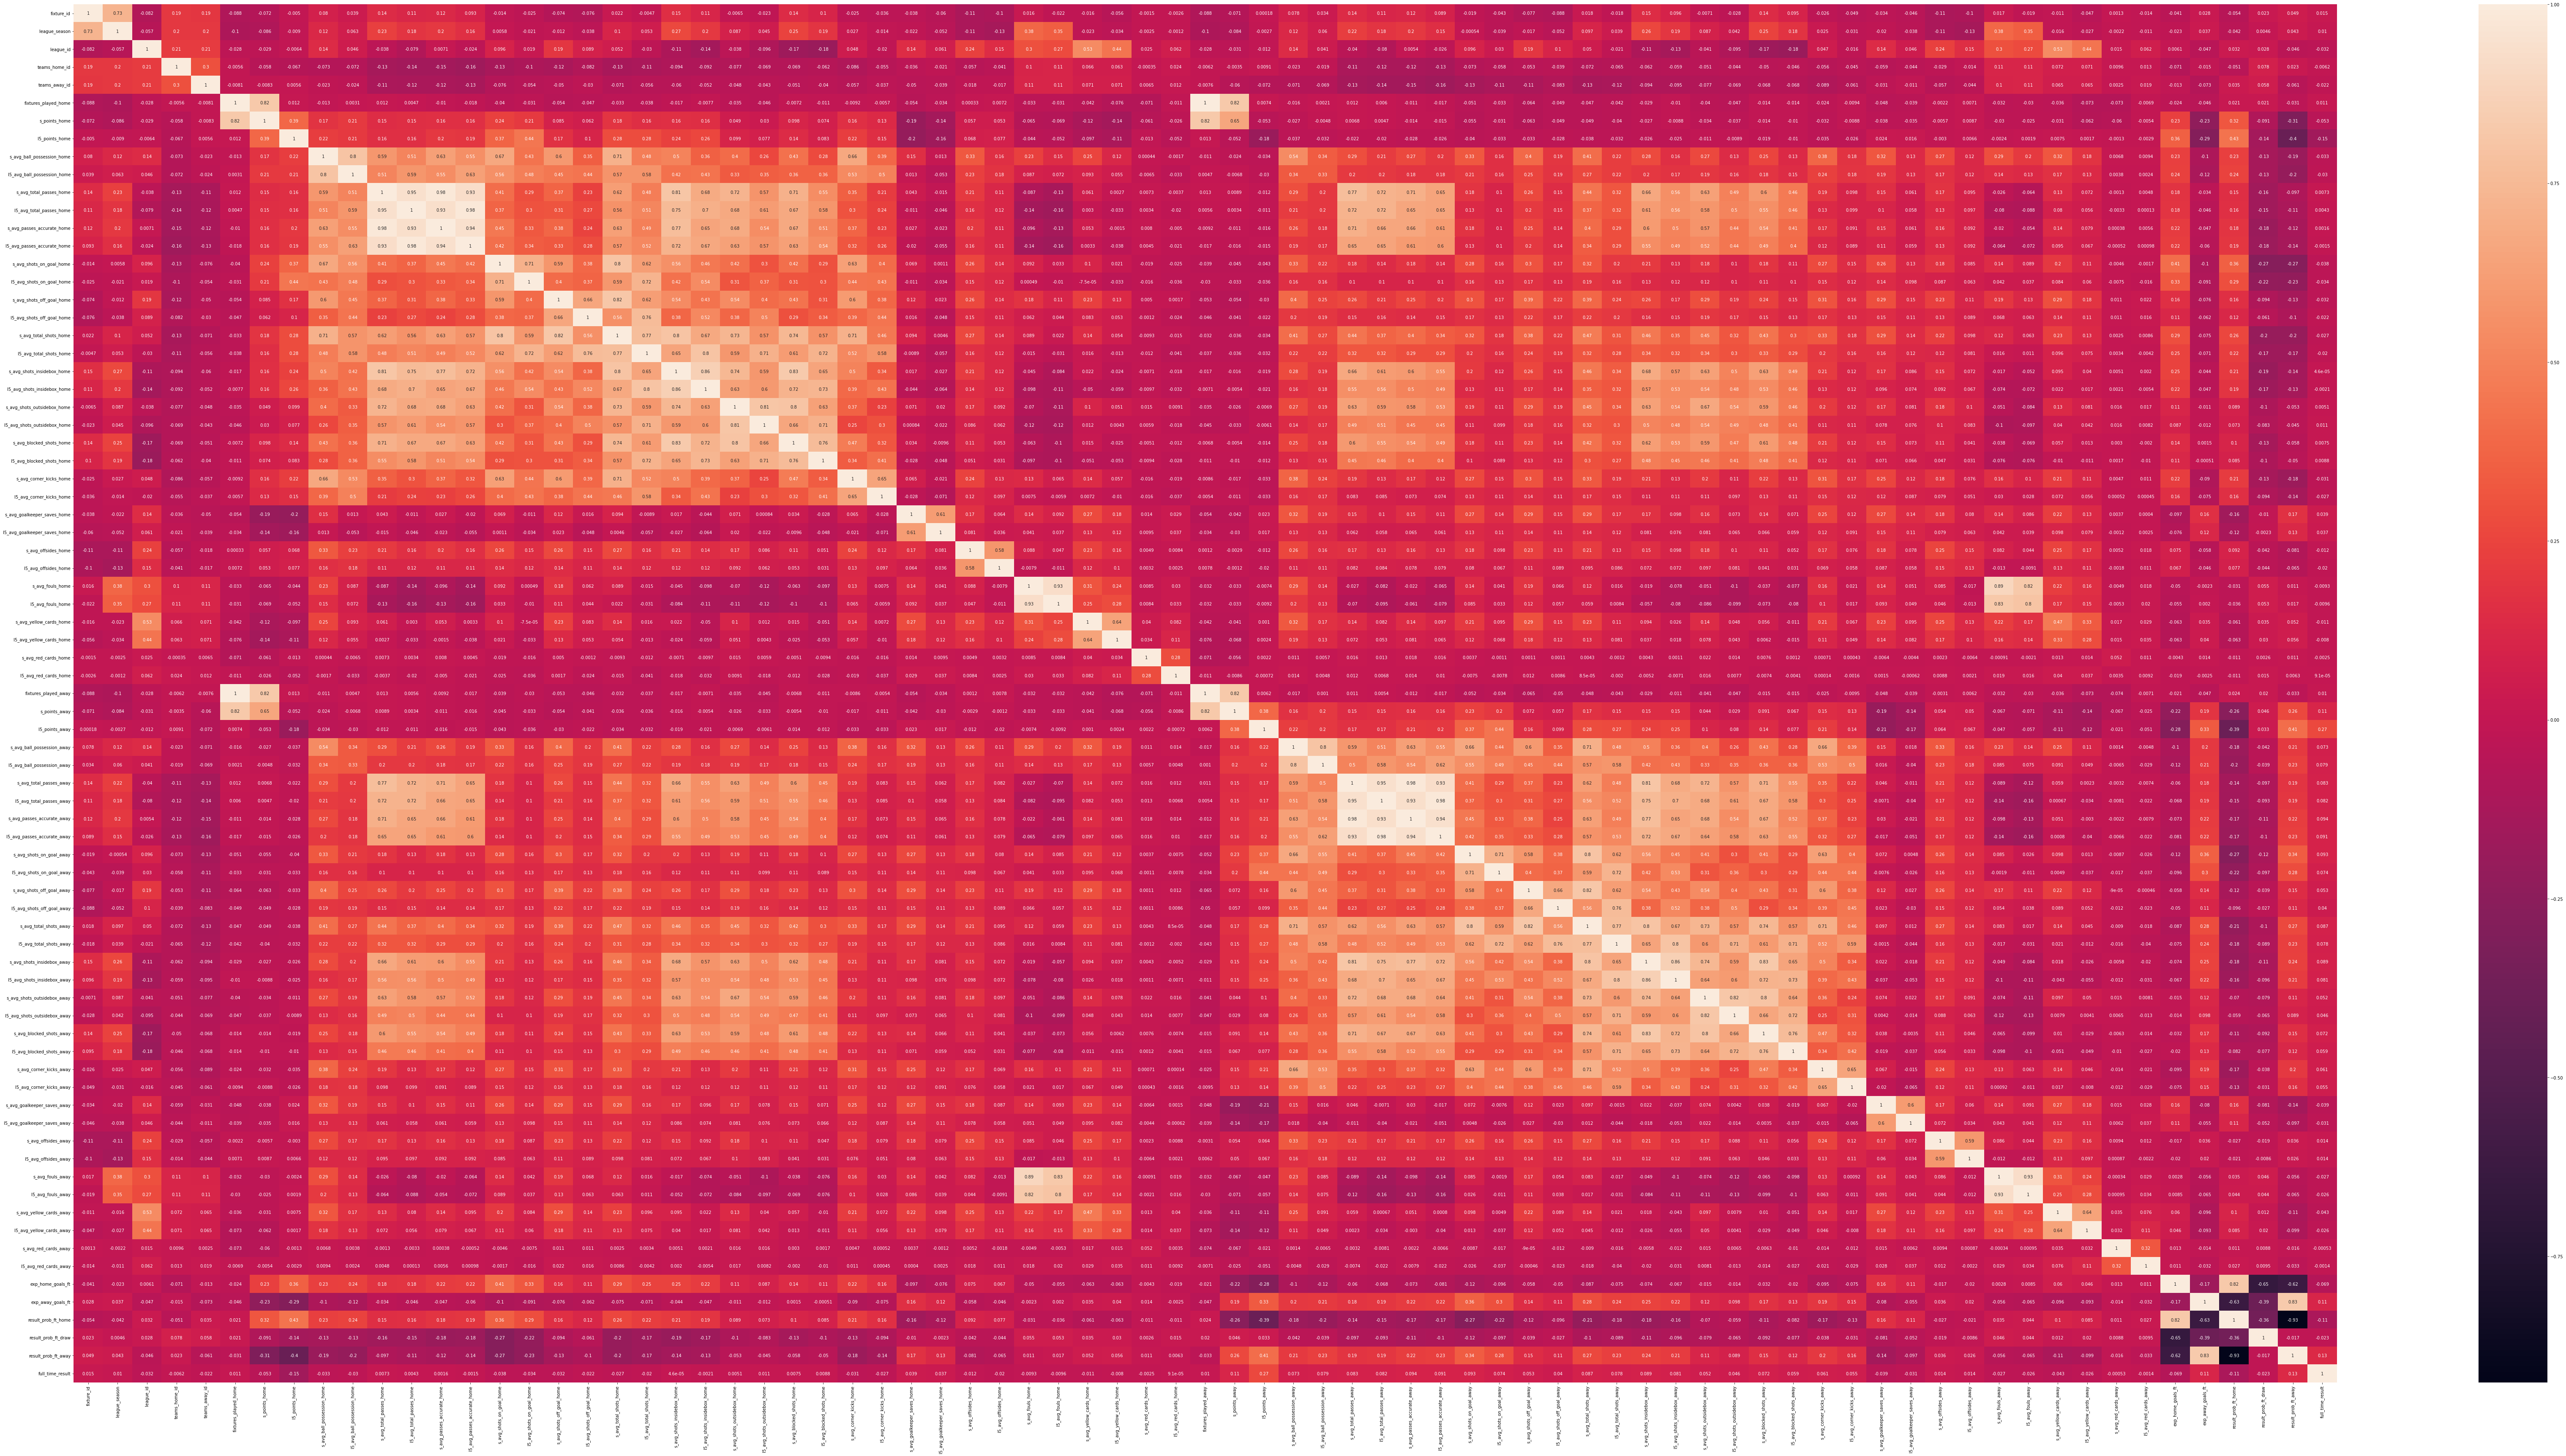

In [5]:
cor = betstats_data.corr()

plt.figure(figsize=(120, 60))
sns.heatmap(cor, annot=True)

## Odds Preperation

In [6]:
odds_data = pd.read_csv('football_fixtures_odds.csv')

odds_data = odds_data.dropna()

display(odds_data)

fixture_id  B365H  B365D  B365A
0              65   1.57    3.9   7.50
1              66   3.90    3.5   2.04
2              67   1.90    3.6   4.50
3              68   2.50    3.4   3.00
4              69   6.50    4.0   1.61
...           ...    ...    ...    ...
32334      768972   1.45    4.0   7.50
32335      768973   2.70    3.1   2.40
32336      768974   4.33    3.2   1.85
32337      768975   2.10    3.2   3.30
32338      768976   3.60    3.2   2.00

[32149 rows x 4 columns]

## Machine Learning Preparation

This section prepares the data for machine learning processing and training. In-line comments explain what everything does.

In [7]:
# Getting column information
col_list = []

for col in betstats_data.columns:
    col_list.append(col)
    
col_len = len(col_list)
col_adj = col_len - 1
    
# print(col_len)
# print(col_list)


# Allocating all of the features to 'x' and the label (full_time_result) to 'y'
x = betstats_data[[col for col in col_list[0:col_adj]]].astype(float)
y = betstats_data[[col for col in col_list[col_adj:]]]

# Categorising the labels (0/1/2)
y = np_utils.to_categorical(y)
# print(y)


# Splitting the records into an 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fixture IDs List:
fix_pred_list = x_test['fixture_id'].tolist()
fix_pred_list_int = [int(i) for i in fix_pred_list]


# Dropping 'fixture_id' from the datasets containing features
x_train = x_train.drop('fixture_id', axis=1)
x_test = x_test.drop('fixture_id', axis=1)

# display(x_test)


# Datasets Shape Information
print('x_train Shape:', x_train.shape)
print('y_train Shape:', y_train.shape)
print('x_test Shape:', x_test.shape)
print('y_test Shape:', y_test.shape)

x_train Shape: (19252, 75)
y_train Shape: (19252, 3)
x_test Shape: (4813, 75)
y_test Shape: (4813, 3)


## Preparing Pieces of Text To Give Prediction Context (XAI)

Below, one can see 2 different pieces of text for each scenario. Depending on the data and prediction of a particular record, the most appropriate paragraph is selected.

In [8]:
# HOME WIN
xai_01 = """The home team has been outperforming the away team throughout most of the season. They have also performed
            better than the away team in the last couple of matches. This means that the overall attacking and 
            defensive performance of the home team surpasses that of the away team."""

xai_02 = """In the last couple of games, the home team was clinical in front of the post and made their chances count.
            Through this analysis, it is highly likely that the home team collects the 3 points."""


# DRAW
xai_03 = """Both teams are similarly balanced going into this fixture. The attacking and defensive capabilities of
            these teams have been of equal level over the last couple of games. Therefore, it is likely that a draw occurs."""

xai_04 = """Judging from recent performance, both teams seem level going head-to-head. Data suggests that 
            the teams are most likely to share a point each."""


# AWAY WIN
xai_05 = """The away team has been outperforming the home team throughout most of the season. They have also performed
            better than the home team in the last couple of matches. This means that the overall attacking and 
            defensive performance of the away team surpasses that of the home team."""

xai_06 = """Although the away team is playing on the opponent's turf, it is still highly likely that they will end up
            taking 3 points. Their team dynamic and recent performance suggests that they should have a competitive edge
            over the home team."""

## GridSearchCV Sequential Model

Testing several paramaters using GridSearchCV on the Sequential Keras model.

In [9]:
# Generating the function that will test all of the different parameters

# The values in the brackets are placeholders incase the input is invalid
def keras_model(optimizer='Adam', loss='categorical_crossentropy', activation='relu',
                 dense_num=256, scoring='accuracy', dropout=0.1):
    # Creating the layers of the NN
    model = Sequential()
    model.add(Dense(dense_num, input_dim=col_adj-1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units=3, activation=activation))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [10]:
# Testing all of the following combinations
param_grid = {
    'epochs': [50, 100, 125],
    'batch_size':[32, 64, 128, 256],
    'dense_num': [25, 50, 75],
    'optimizer':['Adam', 'sgd'],
    'dropout': [0.0001],
    'activation': ['softmax', 'relu'],
    'loss': ['categorical_crossentropy']
}

model = KerasClassifier(build_fn=keras_model, verbose=2)

# Performing 5 kfold cross validation
kfold_cross_validation = 5

# n_jobs=-1 utilises all CPU cores
model_grid = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=kfold_cross_validation,
                          return_train_score=True,
                          n_jobs=-1,
                          verbose=2)

# Fitting the models
model = model_grid.fit(x_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Epoch 1/125
602/602 - 0s - loss: 10.0856 - accuracy: 0.4204
Epoch 2/125
602/602 - 0s - loss: 4.6337 - accuracy: 0.4710
Epoch 3/125
602/602 - 0s - loss: 3.9084 - accuracy: 0.4852
Epoch 4/125
602/602 - 0s - loss: 3.9170 - accuracy: 0.4856
Epoch 5/125
602/602 - 0s - loss: 3.5186 - accuracy: 0.4973
Epoch 6/125
602/602 - 0s - loss: 3.0997 - accuracy: 0.5066
Epoch 7/125
602/602 - 0s - loss: 3.4323 - accuracy: 0.4959
Epoch 8/125
602/602 - 0s - loss: 3.0367 - accuracy: 0.5046
Epoch 9/125
602/602 - 0s - loss: 3.0389 - accuracy: 0.5084
Epoch 10/125
602/602 - 0s - loss: 2.7941 - accuracy: 0.5137
Epoch 11/125
602/602 - 0s - loss: 2.9636 - accuracy: 0.5075
Epoch 12/125
602/602 - 0s - loss: 2.9327 - accuracy: 0.5127
Epoch 13/125
602/602 - 0s - loss: 3.0515 - accuracy: 0.5109
Epoch 14/125
602/602 - 0s - loss: 2.8023 - accuracy: 0.5179
Epoch 15/125
602/602 - 0s - loss: 2.8273 - accuracy: 0.5188
Epoch 16/125
602/602 - 0s - loss: 2.6127 - ac

In [11]:
# Summarising the GridSeachCV Results
params_df = pd.DataFrame(model.cv_results_)
params_df_clean = params_df[['param_epochs', 'param_batch_size', 'param_dense_num',
                             'param_optimizer', 'param_activation',
                             'param_loss', 'mean_test_score', 'rank_test_score']]
params_df_clean = params_df_clean.sort_values('rank_test_score')

print(f'\n\nBest Parameters: {model.best_params_}')
print(f'Best Score: {model.best_score_}')

display(params_df_clean)

params_df_clean.to_csv('keras_nn_best_params.csv', index=False)



Best Parameters: {'activation': 'softmax', 'batch_size': 32, 'dense_num': 50, 'dropout': 0.0001, 'epochs': 125, 'loss': 'categorical_crossentropy', 'optimizer': 'Adam'}
Best Score: 0.5984835147857666


param_epochs param_batch_size param_dense_num param_optimizer  \
10           125               32              50            Adam   
16           125               32              75            Adam   
22           125               64              25            Adam   
26           100               64              50            Adam   
14           100               32              75            Adam   
..           ...              ...             ...             ...   
110          100              128              25            Adam   
108           50              128              25            Adam   
101          125               64              50             sgd   
128          100              256              25            Adam   
109           50              128              25             sgd   

    param_activation                param_loss  mean_test_score  \
10           softmax  categorical_crossentropy         0.598484   
16           softmax  categorical_crossentropy         0.592770   
22           softmax  categorical_crossentropy         0.586847   
26           softmax  categorical_crossentropy         0.585604   
14           softmax  categorical_crossentropy         0.583318   
..               ...                       ...              ...   
110             relu  categorical_crossentropy         0.271036   
108             relu  categorical_crossentropy         0.271036   
101             relu  categorical_crossentropy         0.271036   
128             relu  categorical_crossentropy         0.271036   
109             relu  categorical_crossentropy         0.271036   

     rank_test_score  
10                 1  
16                 2  
22                 3  
26                 4  
14                 5  
..               ...  
110              139  
108              139  
101              139  
128              139  
109              139  

[144 rows x 8 columns]

In [12]:
# Depicting the best model and score
best_model = model_grid.best_estimator_
print(best_model)

score = best_model.score(x_test, y_test)
print(score)

151/151 - 0s - loss: 0.8927 - accuracy: 0.5890
0.5890297293663025


## Best Parameter Sequential Model

Using the best paramaters from the GridSearchCV to conduct predictions with the best set. Afterwards, the accuracy rate and score is determined.

In [13]:
model = Sequential()
model.add(Dense(75, input_dim=col_adj-1, activation='relu'))
model.add(Dropout(0.0001))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, batch_size=32, verbose=2, validation_split=0.1, epochs=125, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 75)                5700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 228       
Total params: 5,928
Trainable params: 5,928
Non-trainable params: 0
_________________________________________________________________
Epoch 1/125
542/542 - 0s - loss: 18.5911 - accuracy: 0.4075 - val_loss: 5.2308 - val_accuracy: 0.3816
Epoch 2/125
542/542 - 0s - loss: 4.1167 - accuracy: 0.4685 - val_loss: 3.1254 - val_accuracy: 0.4761
Epoch 3/125
542/542 - 0s - loss: 3.5818 - accuracy: 0.4786 - val_loss: 5.0322 - val_accuracy: 0.3962
Epoch 4/125
542/542 - 0s - loss: 3.2891 - accuracy: 0.4920 - val_loss: 4.5393 

542/542 - 0s - loss: 0.8611 - accuracy: 0.5955 - val_loss: 0.9111 - val_accuracy: 0.5831
Epoch 75/125
542/542 - 0s - loss: 0.8610 - accuracy: 0.5943 - val_loss: 0.8735 - val_accuracy: 0.5815
Epoch 76/125
542/542 - 0s - loss: 0.8647 - accuracy: 0.5922 - val_loss: 0.8536 - val_accuracy: 0.5919
Epoch 77/125
542/542 - 0s - loss: 0.8629 - accuracy: 0.5954 - val_loss: 0.8602 - val_accuracy: 0.5779
Epoch 78/125
542/542 - 0s - loss: 0.8554 - accuracy: 0.5976 - val_loss: 0.8592 - val_accuracy: 0.5852
Epoch 79/125
542/542 - 0s - loss: 0.8583 - accuracy: 0.5943 - val_loss: 0.8541 - val_accuracy: 0.5961
Epoch 80/125
542/542 - 0s - loss: 0.8550 - accuracy: 0.5947 - val_loss: 0.8520 - val_accuracy: 0.5774
Epoch 81/125
542/542 - 0s - loss: 0.8525 - accuracy: 0.5962 - val_loss: 0.8559 - val_accuracy: 0.5815
Epoch 82/125
542/542 - 0s - loss: 0.8603 - accuracy: 0.5916 - val_loss: 0.8488 - val_accuracy: 0.5966
Epoch 83/125
542/542 - 0s - loss: 0.8522 - accuracy: 0.5983 - val_loss: 0.8511 - val_accuracy: 

In [14]:
# Predicting Using Sequential Model
pred_test = model.predict(x_test)
print(pred_test)

y_pred_classes = np.argmax(pred_test, axis=1)
print(y_pred_classes)

score = model.evaluate(x_test, y_test)
print('Accuracy Score:', score)

[[0.16655971 0.8032551  0.03018515]
 [0.3439862  0.2913027  0.36471108]
 [0.33078763 0.45365462 0.21555781]
 ...
 [0.31592053 0.18264243 0.50143707]
 [0.2140656  0.73078156 0.05515281]
 [0.32366437 0.20118    0.4751557 ]]
[1 2 1 ... 2 1 2]
151/151 [==============================] - 0s 320us/step - loss: 0.8367 - accuracy: 0.5984
Accuracy Score: [0.8367369771003723, 0.598379373550415]


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 75)                5700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 228       
Total params: 5,928
Trainable params: 5,928
Non-trainable params: 0
_________________________________________________________________


In [16]:
y_test_arg = np.argmax(y_test, axis=1)

# Actual
print('Actual amount of labels:')

unique, counts = np.unique(y_test_arg, return_counts=True)
dict(zip(unique, counts))

Actual amount of labels:


{0: 1320, 1: 2145, 2: 1348}

In [17]:
# Prediction
print('Predicted amount of labels:')

unique, counts = np.unique(y_pred_classes, return_counts=True)
dict(zip(unique, counts))

Predicted amount of labels:


{0: 319, 1: 2510, 2: 1984}

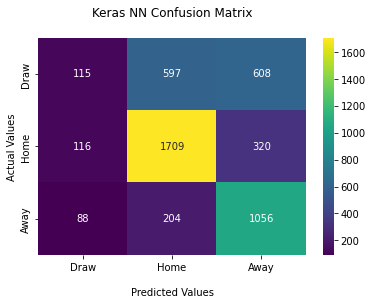

In [18]:
y_test_arg = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_arg, y_pred_classes)

ax = sns.heatmap(cf_matrix, annot=True, cmap='viridis', fmt='d')

ax.set_title('Keras NN Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

# Ticket labels - List must be in alphabetical order
# 0 = Draw
# 1 = Home
# 2 = Away
ax.xaxis.set_ticklabels(['Draw', 'Home', 'Away'])
ax.yaxis.set_ticklabels(['Draw', 'Home', 'Away'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [19]:
print(classification_report(y_test_arg, y_pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.09      0.14      1320
           1       0.68      0.80      0.73      2145
           2       0.53      0.78      0.63      1348

    accuracy                           0.60      4813
   macro avg       0.52      0.56      0.50      4813
weighted avg       0.55      0.60      0.54      4813



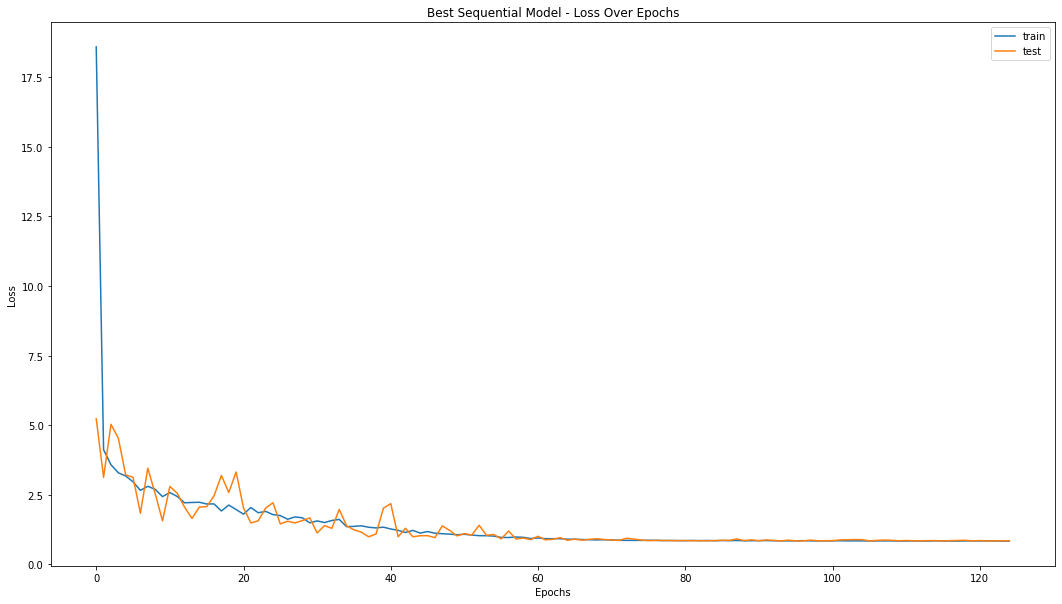

In [20]:
pyplot.figure(figsize=(18,10), dpi=72)
pyplot.title('Best Sequential Model - Loss Over Epochs')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

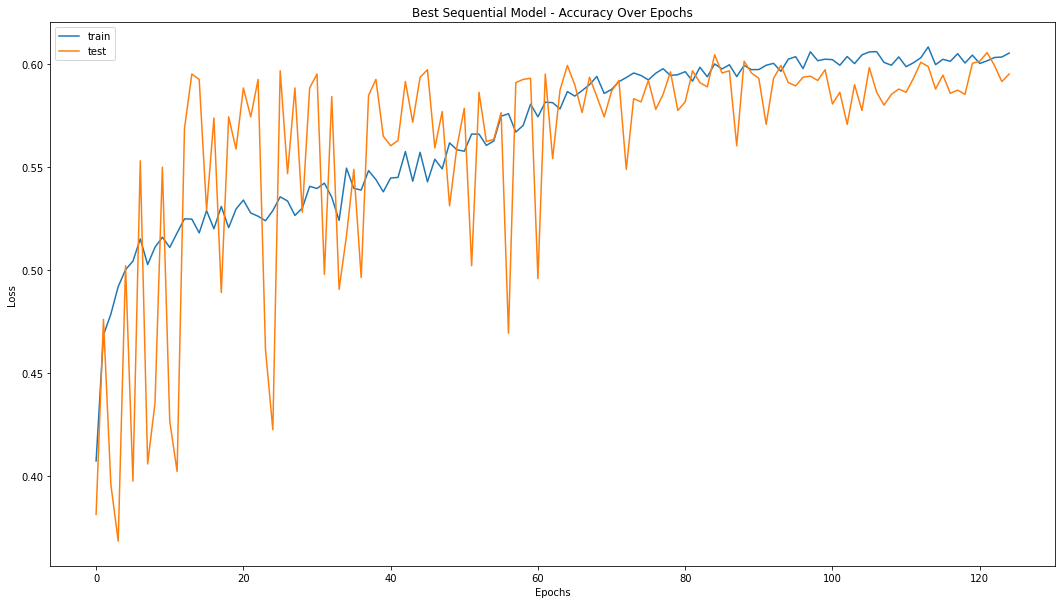

In [21]:
pyplot.figure(figsize=(18,10), dpi=72)
pyplot.title('Best Sequential Model - Accuracy Over Epochs')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

In [22]:
# Appending information obtained from the ML model to the DataFrame

# If we do not add .copy(), the changes will also be reflected on the original 'x_test' DataFrame
new_x_test = x_test.copy()

# Creating new columns to add valuable information to them
new_x_test['fixture_id'] = fix_pred_list_int
new_x_test['result'] = y_pred_classes
new_x_test['orig_result_prob_ft_home'] = None
new_x_test['orig_result_prob_ft_draw'] = None
new_x_test['orig_result_prob_ft_away'] = None
new_x_test['result_prob_ft_home'] = None
new_x_test['result_prob_ft_draw'] = None
new_x_test['result_prob_ft_away'] = None
new_x_test['explainable_ai'] = None

In [23]:
# We have to reset the index due to looping on the row number
new_x_test = new_x_test.reset_index()

for i in range(0, len(new_x_test)):
    home_win_prob = pred_test[i][1]
    draw_prob = pred_test[i][0]
    away_win_prob = pred_test[i][2]
    
    # Getting the rank in its original format
    prob_index_list = [home_win_prob, draw_prob, away_win_prob]                
    min_pos = prob_index_list.index(min(prob_index_list))
    max_pos = prob_index_list.index(max(prob_index_list))
    # combo_list = [0, 1, 2]
    # combo_list.remove([min_pos, max_pos])
    # # Setting 'mid_pos' to the remaining element in 'combo_list'
    # mid_pos = combo_list[0]
    
    
    # Checking if the total equates to 1 exactly or not
    sum_prob_ft = round(home_win_prob, 2) + round(draw_prob, 2) + round(away_win_prob, 2)
    
    # If sum of probability is smaller than 1
    if sum_prob_ft < 1:
        if max_pos == 1:
            diff_prob = 1 - sum_prob_ft
            home_win_prob += diff_prob
        elif max_pos == 0:
            diff_prob = 1 - sum_prob_ft
            draw_prob += diff_prob
        else:
            diff_prob = 1 - sum_prob_ft
            away_win_prob += diff_prob
    
    # If sum of probability is greater than 1
    elif sum_prob_ft > 1:
        if min_pos == 1:
            diff_prob = sum_prob_ft - 1
            home_win_prob -= diff_prob
        elif min_pos == 0:
            diff_prob = sum_prob_ft - 1
            draw_prob -= diff_prob
        else:
            diff_prob = sum_prob_ft - 1
            away_win_prob -= diff_prob
            
    # Setting the original values    
    new_x_test.at[i, 'orig_result_prob_ft_home'] = home_win_prob
    new_x_test.at[i, 'orig_result_prob_ft_draw'] = draw_prob
    new_x_test.at[i, 'orig_result_prob_ft_away'] = away_win_prob

    # Rounding and setting the values    
    new_x_test.at[i, 'result_prob_ft_home'] = round(home_win_prob, 2)
    new_x_test.at[i, 'result_prob_ft_draw'] = round(draw_prob, 2)
    new_x_test.at[i, 'result_prob_ft_away'] = round(away_win_prob, 2)
    
    # Selecting a XAI paragraph that was listed in the previous section
    # Home Win
    if new_x_test.iloc[i]['result'] == 1:
        new_x_test.at[i, 'explainable_ai'] = random.choice([1, 2])
    # Draw
    elif new_x_test.iloc[i]['result'] == 0:
        new_x_test.at[i, 'explainable_ai'] = random.choice([3, 4])
    # Away Win
    else:
        new_x_test.at[i, 'explainable_ai'] = random.choice([5, 6])    
    
# new_x_test['sum_prob'] = round(pd.to_numeric(new_x_test['result_prob_ft_home'] + new_x_test['result_prob_ft_draw'] + new_x_test['result_prob_ft_away']), 2)

display(new_x_test)

index  league_season  league_id  teams_home_id  teams_away_id  \
0     26810         2021.0       79.0          162.0          158.0   
1      7191         2016.0      141.0          799.0          716.0   
2      1596         2018.0       79.0          175.0          181.0   
3     23820         2020.0       41.0         1337.0         1363.0   
4     16570         2015.0      135.0          496.0          519.0   
...     ...            ...        ...            ...            ...   
4808  21288         2020.0       61.0          106.0           95.0   
4809   3885         2017.0       78.0          166.0          170.0   
4810  26410         2021.0       42.0         1819.0         1343.0   
4811    188         2018.0       39.0           40.0           46.0   
4812  14714         2019.0       41.0         1356.0         1358.0   

      fixtures_played_home  s_points_home  l5_points_home  \
0                     19.0           32.0            13.0   
1                      9.0           15.0            10.0   
2                     26.0           50.0            10.0   
3                     36.0           33.0             7.0   
4                     36.0           88.0            18.0   
...                    ...            ...             ...   
4808                   8.0            9.0             9.0   
4809                  26.0           32.0             5.0   
4810                  23.0           23.0             4.0   
4811                  24.0           61.0            13.0   
4812                  14.0           21.0             9.0   

      s_avg_ball_possession_home  l5_avg_ball_possession_home  ...  \
0                           56.0                         54.0  ...   
1                           49.0                         45.0  ...   
2                           61.0                         58.0  ...   
3                           41.0                         38.0  ...   
4                           55.0                         50.0  ...   
...                          ...                          ...  ...   
4808                        51.0                         49.0  ...   
4809                        48.0                         47.0  ...   
4810                        51.0                         54.0  ...   
4811                        48.0                         63.0  ...   
4812                        48.0                         49.0  ...   

      exp_away_goals_ft  result_prob_ft_home  result_prob_ft_draw  \
0                 1.053                  0.8                 0.17   
1                 3.668                 0.29                 0.34   
2                 0.895                 0.45                 0.33   
3                 0.910                 0.15                  0.3   
4                 0.230                 0.91                 0.08   
...                 ...                  ...                  ...   
4808              1.341                 0.52                 0.32   
4809              1.145                 0.13                 0.33   
4810              1.060                 0.18                 0.32   
4811              0.559                 0.73                 0.21   
4812              0.911                  0.2                 0.32   

      result_prob_ft_away  fixture_id  result  orig_result_prob_ft_home  \
0                    0.03      719205       1                  0.803255   
1                    0.37       21190       2                  0.291303   
2                    0.22        3050       1                  0.453655   
3                    0.55      595582       2                  0.150461   
4                    0.01      196755       1                  0.911109   
...                   ...         ...     ...                       ...   
4808                 0.16      571544       1                  0.518063   
4809                 0.54       10998       2                  0.133103   
4810                  0.5      717636       2                  0.182642   


In [24]:
# Reordering DataFrame columns
new_x_test = new_x_test[['fixture_id', 'league_season', 'league_id', 'teams_home_id', 'teams_away_id', 'fixtures_played_home',
                         's_points_home', 'l5_points_home', 's_avg_ball_possession_home', 'l5_avg_ball_possession_home',
                         's_avg_total_passes_home', 'l5_avg_total_passes_home', 's_avg_passes_accurate_home',
                         'l5_avg_passes_accurate_home', 's_avg_shots_on_goal_home', 'l5_avg_shots_on_goal_home',
                         's_avg_shots_off_goal_home', 'l5_avg_shots_off_goal_home', 's_avg_total_shots_home',
                         'l5_avg_total_shots_home', 's_avg_shots_insidebox_home', 'l5_avg_shots_insidebox_home',
                         's_avg_shots_outsidebox_home', 'l5_avg_shots_outsidebox_home', 's_avg_blocked_shots_home',
                         'l5_avg_blocked_shots_home', 's_avg_corner_kicks_home', 'l5_avg_corner_kicks_home',
                         's_avg_goalkeeper_saves_home', 'l5_avg_goalkeeper_saves_home', 's_avg_offsides_home',
                         'l5_avg_offsides_home', 's_avg_fouls_home', 'l5_avg_fouls_home', 's_avg_yellow_cards_home',
                         'l5_avg_yellow_cards_home', 's_avg_red_cards_home', 'l5_avg_red_cards_home', 'fixtures_played_away',
                         's_points_away', 'l5_points_away', 's_avg_ball_possession_away', 'l5_avg_ball_possession_away',
                         's_avg_total_passes_away', 'l5_avg_total_passes_away', 's_avg_passes_accurate_away',
                         'l5_avg_passes_accurate_away', 's_avg_shots_on_goal_away', 'l5_avg_shots_on_goal_away',
                         's_avg_shots_off_goal_away', 'l5_avg_shots_off_goal_away', 's_avg_total_shots_away',
                         'l5_avg_total_shots_away', 's_avg_shots_insidebox_away', 'l5_avg_shots_insidebox_away',
                         's_avg_shots_outsidebox_away', 'l5_avg_shots_outsidebox_away', 's_avg_blocked_shots_away',
                         'l5_avg_blocked_shots_away', 's_avg_corner_kicks_away', 'l5_avg_corner_kicks_away',
                         's_avg_goalkeeper_saves_away', 'l5_avg_goalkeeper_saves_away', 's_avg_offsides_away',
                         'l5_avg_offsides_away', 's_avg_fouls_away', 'l5_avg_fouls_away', 's_avg_yellow_cards_away',
                         'l5_avg_yellow_cards_away', 's_avg_red_cards_away', 'l5_avg_red_cards_away', 'exp_home_goals_ft',
                         'exp_away_goals_ft', 'result_prob_ft_home', 'result_prob_ft_draw', 'result_prob_ft_away',
                         'orig_result_prob_ft_home', 'orig_result_prob_ft_draw', 'orig_result_prob_ft_away',
                         'result', 'explainable_ai']]

### Gambling Simulation

In [25]:
beststats_data_result_only = betstats_data[['fixture_id', 'full_time_result']]

merge_actual_vs_pred = new_x_test.merge(beststats_data_result_only, on='fixture_id')

# Full time result is the actual result and result is the predicted result
merge_actual_vs_pred = merge_actual_vs_pred[['fixture_id', 'league_season', 'league_id', 'teams_home_id', 'teams_away_id',
                                             'full_time_result', 'result']]

merge_odds = merge_actual_vs_pred.merge(odds_data, on='fixture_id')

merge_odds['correct_pred'] = np.where(merge_odds['full_time_result'] == merge_odds['result'],
                                      1, 0)

# Setting a flat bet of €10 and pre-allocating a loss of -€10
# The loss will be updated based on the prediction
merge_odds['money_bet'] = 10
merge_odds['profit'] = -10

merge_odds['profit'] = np.where((merge_odds['full_time_result'] == 0) & (merge_odds['result'] == 0),
                                 merge_odds['money_bet'] * merge_odds['B365D'] - 10, merge_odds['profit'])
merge_odds['profit'] = np.where((merge_odds['full_time_result'] == 1) & (merge_odds['result'] == 1),
                                 merge_odds['money_bet'] * merge_odds['B365H'] - 10, merge_odds['profit'])
merge_odds['profit'] = np.where((merge_odds['full_time_result'] == 2) & (merge_odds['result'] == 2),
                                 merge_odds['money_bet'] * merge_odds['B365A'] - 10, merge_odds['profit'])

display(merge_odds)

fixture_id  league_season  league_id  teams_home_id  teams_away_id  \
0         719205         2021.0       79.0          162.0          158.0   
1          21190         2016.0      141.0          799.0          716.0   
2           3050         2018.0       79.0          175.0          181.0   
3         595582         2020.0       41.0         1337.0         1363.0   
4         196755         2015.0      135.0          496.0          519.0   
...          ...            ...        ...            ...            ...   
4774      571544         2020.0       61.0          106.0           95.0   
4775       10998         2017.0       78.0          166.0          170.0   
4776      717636         2021.0       42.0         1819.0         1343.0   
4777         303         2018.0       39.0           40.0           46.0   
4778      168090         2019.0       41.0         1356.0         1358.0   

      full_time_result  result  B365H  B365D  B365A  correct_pred  money_bet  \
0                    1       1   1.75   4.00   4.33             1         10   
1                    0       2   2.15   3.20   3.50             0         10   
2                    2       1   1.50   4.00   7.00             0         10   
3                    2       2   2.80   3.40   2.50             1         10   
4                    1       1   1.25   5.50  13.00             1         10   
...                ...     ...    ...    ...    ...           ...        ...   
4774                 2       1   2.15   3.50   3.20             0         10   
4775                 2       2   2.14   3.39   3.39             1         10   
4776                 2       2   2.55   3.25   2.87             1         10   
4777                 0       1   1.22   7.00  15.00             0         10   
4778                 0       2   2.35   3.60   3.10             0         10   

      profit  
0        7.5  
1      -10.0  
2      -10.0  
3       15.0  
4        2.5  
...      ...  
4774   -10.0  
4775    23.9  
4776    18.7  
4777   -10.0  
4778   -10.0  

[4779 rows x 13 columns]

In [26]:
print(f"Total Matches: {len(merge_odds)}")
print(f"Total Correct Predictions: {merge_odds['correct_pred'].sum()}")
print(f"Correct Prediction Percentage: {round(((merge_odds['correct_pred'].sum() / len(merge_odds)) * 100), 2)}%")

print(f"\nTotal Bets Placed: €{round(merge_odds['money_bet'].sum(), 2)}")
print(f"Total Profit: €{round(merge_odds['profit'].sum(), 2)}")
print(f"Return on Investment: {round((merge_odds['money_bet'].sum() + merge_odds['profit'].sum()) / merge_odds['money_bet'].sum() * 100, 2)}%")
print(f"Yield: {round((merge_odds['money_bet'].sum() + merge_odds['profit'].sum()) / merge_odds['money_bet'].sum() * 100, 2) - 100}%")

Total Matches: 4779
Total Correct Predictions: 2865
Correct Prediction Percentage: 59.95%

Total Bets Placed: €47790
Total Profit: €20446.1
Return on Investment: 142.78%
Yield: 42.78%


## GridSearchCV RandomForest Model

Testing several paramaters using GridSearchCV on the scikit-learn RandomForest model.

In [27]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'max_features': [10, 50],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90],
                         'max_features': [10, 50], 'min_samples_leaf': [3, 4],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [28]:
# Summarising the GridSeachCV Results
params_df = pd.DataFrame(grid_search.cv_results_)
params_df_clean = params_df[['param_bootstrap', 'param_max_depth',
                             'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split',
                             'param_n_estimators', 'mean_test_score', 'rank_test_score']] 
params_df_clean = params_df_clean.sort_values('rank_test_score')

print(f'\n\nBest Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

best_grid = grid_search.best_estimator_

display(params_df_clean)

params_df_clean.to_csv('random_forest_best_params.csv', index=False)



Best Parameters: {'bootstrap': True, 'max_depth': 90, 'max_features': 50, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.4521091704971217


param_bootstrap param_max_depth param_max_features param_min_samples_leaf  \
30            True              90                 50                      4   
26            True              90                 50                      3   
10            True              80                 50                      3   
29            True              90                 50                      4   
28            True              90                 50                      4   
12            True              80                 50                      4   
14            True              80                 50                      4   
13            True              80                 50                      4   
31            True              90                 50                      4   
8             True              80                 50                      3   
15            True              80                 50                      4   
24            True              90                 50                      3   
9             True              80                 50                      3   
25            True              90                 50                      3   
27            True              90                 50                      3   
11            True              80                 50                      3   
20            True              90                 10                      4   
2             True              80                 10                      3   
23            True              90                 10                      4   
0             True              80                 10                      3   
21            True              90                 10                      4   
22            True              90                 10                      4   
17            True              90                 10                      3   
6             True              80                 10                      4   
5             True              80                 10                      4   
16            True              90                 10                      3   
7             True              80                 10                      4   
1             True              80                 10                      3   
19            True              90                 10                      3   
18            True              90                 10                      3   
4             True              80                 10                      4   
3             True              80                 10                      3   

   param_min_samples_split param_n_estimators  mean_test_score  \
30                      10                100         0.452109   
26                      10                100         0.451746   
10                      10                100         0.450759   
29                       8                200         0.450758   
28                       8                100         0.450551   
12                       8                100         0.450499   
14                      10                100         0.449979   
13                       8                200         0.449720   
31                      10                200         0.449512   
8                        8                100         0.449512   
15                      10                200         0.449252   
24                       8                100         0.448837   
9                        8                200         0.448421   
25                       8                200         0.447850   
27                      10                200         0.447434   
11                      10                200         0.446655   
20                       8                100         0.399439   
2                       10                100         0.399024   
23                      10                200         0.398868   
0                        8                

## Best Parameter RandomForest Model

Using the best paramaters from the GridSearchCV to conduct predictions with the best set. Afterwards, the accuracy rate and score is determined.

In [29]:
# Previewing the 'x_test' is still in its original state
x_test

league_season  league_id  teams_home_id  teams_away_id  \
26810         2021.0       79.0          162.0          158.0   
7191          2016.0      141.0          799.0          716.0   
1596          2018.0       79.0          175.0          181.0   
23820         2020.0       41.0         1337.0         1363.0   
16570         2015.0      135.0          496.0          519.0   
...              ...        ...            ...            ...   
21288         2020.0       61.0          106.0           95.0   
3885          2017.0       78.0          166.0          170.0   
26410         2021.0       42.0         1819.0         1343.0   
188           2018.0       39.0           40.0           46.0   
14714         2019.0       41.0         1356.0         1358.0   

       fixtures_played_home  s_points_home  l5_points_home  \
26810                  19.0           32.0            13.0   
7191                    9.0           15.0            10.0   
1596                   26.0           50.0            10.0   
23820                  36.0           33.0             7.0   
16570                  36.0           88.0            18.0   
...                     ...            ...             ...   
21288                   8.0            9.0             9.0   
3885                   26.0           32.0             5.0   
26410                  23.0           23.0             4.0   
188                    24.0           61.0            13.0   
14714                  14.0           21.0             9.0   

       s_avg_ball_possession_home  l5_avg_ball_possession_home  \
26810                        56.0                         54.0   
7191                         49.0                         45.0   
1596                         61.0                         58.0   
23820                        41.0                         38.0   
16570                        55.0                         50.0   
...                           ...                          ...   
21288                        51.0                         49.0   
3885                         48.0                         47.0   
26410                        51.0                         54.0   
188                          48.0                         63.0   
14714                        48.0                         49.0   

       s_avg_total_passes_home  ...  l5_avg_fouls_away  \
26810                    473.0  ...               10.0   
7191                     381.0  ...               15.0   
1596                     519.0  ...               16.0   
23820                    278.0  ...               10.0   
16570                    513.0  ...                0.0   
...                        ...  ...                ...   
21288                    442.0  ...               13.0   
3885                     401.0  ...               14.0   
26410                    372.0  ...               13.0   
188                      495.0  ...                9.0   
14714                    342.0  ...               12.0   

       s_avg_yellow_cards_away  l5_avg_yellow_cards_away  \
26810                      2.0                       2.0   
7191                       2.0                       2.0   
1596                       2.0                       2.0   
23820                      1.0                       1.0   
16570                      3.0                       4.0   
...                        ...                       ...   
21288                      2.0                       2.0   
3885                       2.0                       2.0   
26410                      2.0                       2.0   
188                        1.0                       2.0   
14714                      1.0                       2.0   

       s_avg_red_cards_away  l5_avg_red_cards_away  exp_home_goals_ft  \
26810                   0.0                    0.0              1.347   
7191                    0.0                    0.0              2.097   
1596                    0.0                    0.0 

In [30]:
# Random Forest Model
model = RandomForestClassifier(bootstrap = True,
                               max_depth = 80,
                               max_features = 50,
                               min_samples_leaf = 3,
                               min_samples_split = 8,
                               n_estimators = 100,
                               random_state = 42)

model.fit(x_train, y_train)

RandomForestClassifier(max_depth=80, max_features=50, min_samples_leaf=3,
                       min_samples_split=8, random_state=42)

In [31]:
pred_test = model.predict(x_test)
print(pred_test)

y_pred_classes = np.argmax(pred_test, axis=1)
print(y_pred_classes)

# Actual prediction accuracy
score = model.score(x_test, y_test)
print('Accuracy Score:', score)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[1 2 1 ... 0 1 1]
Accuracy Score: 0.4492000831082485


In [32]:
y_test_arg = np.argmax(y_test, axis=1)

# Actual
print('Actual amount of labels:')

unique, counts = np.unique(y_test_arg, return_counts=True)
dict(zip(unique, counts))

Actual amount of labels:


{0: 1320, 1: 2145, 2: 1348}

In [33]:
# Prediction
print('Predicted amount of labels:')

unique, counts = np.unique(y_pred_classes, return_counts=True)
dict(zip(unique, counts))

Predicted amount of labels:


{0: 1854, 1: 1975, 2: 984}

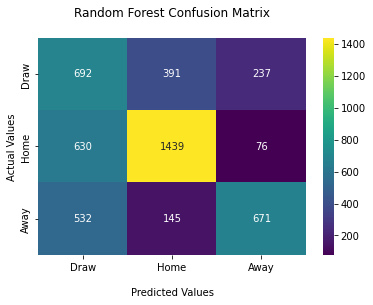

In [34]:
y_test_arg = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_arg, y_pred_classes)

ax = sns.heatmap(cf_matrix, annot=True, cmap='viridis', fmt='d')

ax.set_title('Random Forest Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

# Ticket labels - List must be in alphabetical order
# 0 = Draw
# 1 = Home
# 2 = Away
ax.xaxis.set_ticklabels(['Draw', 'Home', 'Away'])
ax.yaxis.set_ticklabels(['Draw', 'Home', 'Away'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [35]:
print(classification_report(y_test_arg, y_pred_classes))

              precision    recall  f1-score   support

           0       0.37      0.52      0.44      1320
           1       0.73      0.67      0.70      2145
           2       0.68      0.50      0.58      1348

    accuracy                           0.58      4813
   macro avg       0.59      0.56      0.57      4813
weighted avg       0.62      0.58      0.59      4813



In [36]:
# Appending information obtained from the ML model to the DataFrame

# If we do not add .copy(), the changes will also be reflected on the original 'x_test' DataFrame
new_x_test = x_test.copy()

# Creating new columns to add valuable information to them
new_x_test['fixture_id'] = fix_pred_list_int
new_x_test['result'] = y_pred_classes
new_x_test['orig_result_prob_ft_home'] = None
new_x_test['orig_result_prob_ft_draw'] = None
new_x_test['orig_result_prob_ft_away'] = None
new_x_test['result_prob_ft_home'] = None
new_x_test['result_prob_ft_draw'] = None
new_x_test['result_prob_ft_away'] = None
new_x_test['explainable_ai'] = None

In [37]:
# We have to reset the index due to looping on the row number
new_x_test = new_x_test.reset_index()

for i in range(0, len(new_x_test)):
    home_win_prob = pred_test[i][1]
    draw_prob = pred_test[i][0]
    away_win_prob = pred_test[i][2]
    
    # Getting the rank in its original format
    prob_index_list = [home_win_prob, draw_prob, away_win_prob]                
    min_pos = prob_index_list.index(min(prob_index_list))
    max_pos = prob_index_list.index(max(prob_index_list))
    # combo_list = [0, 1, 2]
    # combo_list.remove([min_pos, max_pos])
    # # Setting 'mid_pos' to the remaining element in 'combo_list'
    # mid_pos = combo_list[0]
    
    
    # Checking if the total equates to 1 exactly or not
    sum_prob_ft = round(home_win_prob, 2) + round(draw_prob, 2) + round(away_win_prob, 2)
    
    # If sum of probability is smaller than 1
    if sum_prob_ft < 1:
        if max_pos == 1:
            diff_prob = 1 - sum_prob_ft
            home_win_prob += diff_prob
        elif max_pos == 0:
            diff_prob = 1 - sum_prob_ft
            draw_prob += diff_prob
        else:
            diff_prob = 1 - sum_prob_ft
            away_win_prob += diff_prob
    
    # If sum of probability is greater than 1
    elif sum_prob_ft > 1:
        if min_pos == 1:
            diff_prob = sum_prob_ft - 1
            home_win_prob -= diff_prob
        elif min_pos == 0:
            diff_prob = sum_prob_ft - 1
            draw_prob -= diff_prob
        else:
            diff_prob = sum_prob_ft - 1
            away_win_prob -= diff_prob
            
    # Setting the original values    
    new_x_test.at[i, 'orig_result_prob_ft_home'] = home_win_prob
    new_x_test.at[i, 'orig_result_prob_ft_draw'] = draw_prob
    new_x_test.at[i, 'orig_result_prob_ft_away'] = away_win_prob

    # Rounding and setting the values    
    new_x_test.at[i, 'result_prob_ft_home'] = round(home_win_prob, 2)
    new_x_test.at[i, 'result_prob_ft_draw'] = round(draw_prob, 2)
    new_x_test.at[i, 'result_prob_ft_away'] = round(away_win_prob, 2)
    
    # Selecting a XAI paragraph that was listed in the previous section
    # Home Win
    if new_x_test.iloc[i]['result'] == 1:
        new_x_test.at[i, 'explainable_ai'] = random.choice([1, 2])
    # Draw
    elif new_x_test.iloc[i]['result'] == 0:
        new_x_test.at[i, 'explainable_ai'] = random.choice([3, 4])
    # Away Win
    else:
        new_x_test.at[i, 'explainable_ai'] = random.choice([5, 6])    
    
# new_x_test['sum_prob'] = round(pd.to_numeric(new_x_test['result_prob_ft_home'] + new_x_test['result_prob_ft_draw'] + new_x_test['result_prob_ft_away']), 2)

display(new_x_test)

index  league_season  league_id  teams_home_id  teams_away_id  \
0     26810         2021.0       79.0          162.0          158.0   
1      7191         2016.0      141.0          799.0          716.0   
2      1596         2018.0       79.0          175.0          181.0   
3     23820         2020.0       41.0         1337.0         1363.0   
4     16570         2015.0      135.0          496.0          519.0   
...     ...            ...        ...            ...            ...   
4808  21288         2020.0       61.0          106.0           95.0   
4809   3885         2017.0       78.0          166.0          170.0   
4810  26410         2021.0       42.0         1819.0         1343.0   
4811    188         2018.0       39.0           40.0           46.0   
4812  14714         2019.0       41.0         1356.0         1358.0   

      fixtures_played_home  s_points_home  l5_points_home  \
0                     19.0           32.0            13.0   
1                      9.0           15.0            10.0   
2                     26.0           50.0            10.0   
3                     36.0           33.0             7.0   
4                     36.0           88.0            18.0   
...                    ...            ...             ...   
4808                   8.0            9.0             9.0   
4809                  26.0           32.0             5.0   
4810                  23.0           23.0             4.0   
4811                  24.0           61.0            13.0   
4812                  14.0           21.0             9.0   

      s_avg_ball_possession_home  l5_avg_ball_possession_home  ...  \
0                           56.0                         54.0  ...   
1                           49.0                         45.0  ...   
2                           61.0                         58.0  ...   
3                           41.0                         38.0  ...   
4                           55.0                         50.0  ...   
...                          ...                          ...  ...   
4808                        51.0                         49.0  ...   
4809                        48.0                         47.0  ...   
4810                        51.0                         54.0  ...   
4811                        48.0                         63.0  ...   
4812                        48.0                         49.0  ...   

      exp_away_goals_ft  result_prob_ft_home  result_prob_ft_draw  \
0                 1.053                    1                    0   
1                 3.668                    0                    0   
2                 0.895                    1                    0   
3                 0.910                    0                    1   
4                 0.230                    1                    0   
...                 ...                  ...                  ...   
4808              1.341                    0                    1   
4809              1.145                    0                    0   
4810              1.060                    0                    1   
4811              0.559                    1                    0   
4812              0.911                    1                    0   

      result_prob_ft_away  fixture_id  result  orig_result_prob_ft_home  \
0                       0      719205       1                         1   
1                       1       21190       2                         0   
2                       0        3050       1                         1   
3                       0      595582       0                         0   
4                       0      196755       1                         1   
...                   ...         ...     ...                       ...   
4808                    0      571544       0                         0   
4809                    1       10998       2                         0   
4810                    0      717636       0                         0   


In [38]:
# Reordering DataFrame columns
new_x_test = new_x_test[['fixture_id', 'league_season', 'league_id', 'teams_home_id', 'teams_away_id', 'fixtures_played_home',
                         's_points_home', 'l5_points_home', 's_avg_ball_possession_home', 'l5_avg_ball_possession_home',
                         's_avg_total_passes_home', 'l5_avg_total_passes_home', 's_avg_passes_accurate_home',
                         'l5_avg_passes_accurate_home', 's_avg_shots_on_goal_home', 'l5_avg_shots_on_goal_home',
                         's_avg_shots_off_goal_home', 'l5_avg_shots_off_goal_home', 's_avg_total_shots_home',
                         'l5_avg_total_shots_home', 's_avg_shots_insidebox_home', 'l5_avg_shots_insidebox_home',
                         's_avg_shots_outsidebox_home', 'l5_avg_shots_outsidebox_home', 's_avg_blocked_shots_home',
                         'l5_avg_blocked_shots_home', 's_avg_corner_kicks_home', 'l5_avg_corner_kicks_home',
                         's_avg_goalkeeper_saves_home', 'l5_avg_goalkeeper_saves_home', 's_avg_offsides_home',
                         'l5_avg_offsides_home', 's_avg_fouls_home', 'l5_avg_fouls_home', 's_avg_yellow_cards_home',
                         'l5_avg_yellow_cards_home', 's_avg_red_cards_home', 'l5_avg_red_cards_home', 'fixtures_played_away',
                         's_points_away', 'l5_points_away', 's_avg_ball_possession_away', 'l5_avg_ball_possession_away',
                         's_avg_total_passes_away', 'l5_avg_total_passes_away', 's_avg_passes_accurate_away',
                         'l5_avg_passes_accurate_away', 's_avg_shots_on_goal_away', 'l5_avg_shots_on_goal_away',
                         's_avg_shots_off_goal_away', 'l5_avg_shots_off_goal_away', 's_avg_total_shots_away',
                         'l5_avg_total_shots_away', 's_avg_shots_insidebox_away', 'l5_avg_shots_insidebox_away',
                         's_avg_shots_outsidebox_away', 'l5_avg_shots_outsidebox_away', 's_avg_blocked_shots_away',
                         'l5_avg_blocked_shots_away', 's_avg_corner_kicks_away', 'l5_avg_corner_kicks_away',
                         's_avg_goalkeeper_saves_away', 'l5_avg_goalkeeper_saves_away', 's_avg_offsides_away',
                         'l5_avg_offsides_away', 's_avg_fouls_away', 'l5_avg_fouls_away', 's_avg_yellow_cards_away',
                         'l5_avg_yellow_cards_away', 's_avg_red_cards_away', 'l5_avg_red_cards_away', 'exp_home_goals_ft',
                         'exp_away_goals_ft', 'result_prob_ft_home', 'result_prob_ft_draw', 'result_prob_ft_away',
                         'orig_result_prob_ft_home', 'orig_result_prob_ft_draw', 'orig_result_prob_ft_away',
                         'result', 'explainable_ai']]

### Gambling Simulation

In [39]:
beststats_data_result_only = betstats_data[['fixture_id', 'full_time_result']]

In [40]:
merge_actual_vs_pred = new_x_test.merge(beststats_data_result_only, on='fixture_id')

# Full time result is the actual result and result is the predicted result
merge_actual_vs_pred = merge_actual_vs_pred[['fixture_id', 'league_season', 'league_id', 'teams_home_id', 'teams_away_id',
                                             'full_time_result', 'result']]

merge_odds = merge_actual_vs_pred.merge(odds_data, on='fixture_id')

merge_odds['correct_pred'] = np.where(merge_odds['full_time_result'] == merge_odds['result'],
                                      1, 0)

merge_odds['money_bet'] = 10
merge_odds['profit'] = -10

merge_odds['profit'] = np.where((merge_odds['full_time_result'] == 0) & (merge_odds['result'] == 0),
                                 merge_odds['money_bet'] * merge_odds['B365D'] - 10, merge_odds['profit'])
merge_odds['profit'] = np.where((merge_odds['full_time_result'] == 1) & (merge_odds['result'] == 1),
                                 merge_odds['money_bet'] * merge_odds['B365H'] - 10, merge_odds['profit'])
merge_odds['profit'] = np.where((merge_odds['full_time_result'] == 2) & (merge_odds['result'] == 2),
                                 merge_odds['money_bet'] * merge_odds['B365A'] - 10, merge_odds['profit'])

display(merge_odds)

fixture_id  league_season  league_id  teams_home_id  teams_away_id  \
0         719205         2021.0       79.0          162.0          158.0   
1          21190         2016.0      141.0          799.0          716.0   
2           3050         2018.0       79.0          175.0          181.0   
3         595582         2020.0       41.0         1337.0         1363.0   
4         196755         2015.0      135.0          496.0          519.0   
...          ...            ...        ...            ...            ...   
4774      571544         2020.0       61.0          106.0           95.0   
4775       10998         2017.0       78.0          166.0          170.0   
4776      717636         2021.0       42.0         1819.0         1343.0   
4777         303         2018.0       39.0           40.0           46.0   
4778      168090         2019.0       41.0         1356.0         1358.0   

      full_time_result  result  B365H  B365D  B365A  correct_pred  money_bet  \
0                    1       1   1.75   4.00   4.33             1         10   
1                    0       2   2.15   3.20   3.50             0         10   
2                    2       1   1.50   4.00   7.00             0         10   
3                    2       0   2.80   3.40   2.50             0         10   
4                    1       1   1.25   5.50  13.00             1         10   
...                ...     ...    ...    ...    ...           ...        ...   
4774                 2       0   2.15   3.50   3.20             0         10   
4775                 2       2   2.14   3.39   3.39             1         10   
4776                 2       0   2.55   3.25   2.87             0         10   
4777                 0       1   1.22   7.00  15.00             0         10   
4778                 0       1   2.35   3.60   3.10             0         10   

      profit  
0        7.5  
1      -10.0  
2      -10.0  
3      -10.0  
4        2.5  
...      ...  
4774   -10.0  
4775    23.9  
4776   -10.0  
4777   -10.0  
4778   -10.0  

[4779 rows x 13 columns]

In [41]:
print(f"Total Matches: {len(merge_odds)}")
print(f"Total Correct Predictions: {merge_odds['correct_pred'].sum()}")
print(f"Correct Prediction Percentage: {round(((merge_odds['correct_pred'].sum() / len(merge_odds)) * 100), 2)}%")

print(f"\nTotal Bets Placed: €{round(merge_odds['money_bet'].sum(), 2)}")
print(f"Total Profit: €{round(merge_odds['profit'].sum(), 2)}")
print(f"Return on Investment: {round((merge_odds['money_bet'].sum() + merge_odds['profit'].sum()) / merge_odds['money_bet'].sum() * 100, 2)}%")
print(f"Yield: {round((merge_odds['money_bet'].sum() + merge_odds['profit'].sum()) / merge_odds['money_bet'].sum() * 100, 2) - 100}%")

Total Matches: 4779
Total Correct Predictions: 2787
Correct Prediction Percentage: 58.32%

Total Bets Placed: €47790
Total Profit: €21163.1
Return on Investment: 144.28%
Yield: 44.28%


## Notes

For further visualisations, kindly refer to the entire write-up or by clicking on this [link](https://docs.google.com/spreadsheets/d/1i-WSEkhrl4q6TLL68K2F5h8F2f2bGpYCKbM4Kk3aXQY/edit).